# Task 1: Principal Component Analysis

This notebook is a showcase of our `pca` module, which implements Principal Component Analysis (PCA).

PCA is a method for dimensionality reduction, performing well on affine-linear data.

First, the data is centered by subtracting the average datapoint from each datapoint. Then, we perform singular value decomposition on the centered data.

The trick is to reverse the singular value decomposition by setting the least important singular values to 0, and then multiplying the matrices back together. This is possible because the singular values are ordered by magnitude, and the least important singular values are the ones that contribute the least to the variance in the data.

In [13]:
import init_notebook
from test_module import test_function
from pca import PCA
import matplotlib.pyplot as plt

# Helper module for visualization in this notebook
from pca_utils import *

import numpy as np
import scipy as sc

test_function()

I was imported!


# Principal Component Analysis
We load the data from a file and perform PCA.

It's apparent that one of the principal components accounts for over 99.3% of the variance in the data, which motivates us to the assumption that the other principal component is just noise.

In [14]:
with open("pca_dataset.txt", 'r') as file:
    # Load data inta a Python ndarray, shape (100, 2)
    global data_matrix
    data_matrix = np.loadtxt(file, delimiter=' ')
    assert data_matrix.shape == (100, 2)

pca_result = PCA.pca(data_matrix)

# This is how we can access the data of our PCA result
U, S, Vh, mean = pca_result
E = pca_result.energy

print(f'Energies: {E}\nSingular values ordered by magnitude: {S}')

Energies: [0.99314266 0.00685734]
Singular values ordered by magnitude: [9.94340494 0.82624201]


# Reversing PSA to verify correctness

In [15]:
data_matrix_reconstructed = pca_result.reverse_pca(2)

# Before and after display side-by-side
display_side_by_side = False
if display_side_by_side:
    for o, r in zip(data_matrix, data_matrix_reconstructed):
        print(f'o: {o}, r: {r}')

assert np.allclose(data_matrix, data_matrix_reconstructed)

# Plotting data

The plot looks suspiciously linear, which further supports the assumption that a linear model is very suitable for this dataset. The green principal component seems to be just noise, with no discernable patterns. The points align strongly with the red principal component.

PSA is a great approach for data that shows affine-linear behavior, as opposed to data on curved manifolds. This is why it makes sense to use PSA for this data.

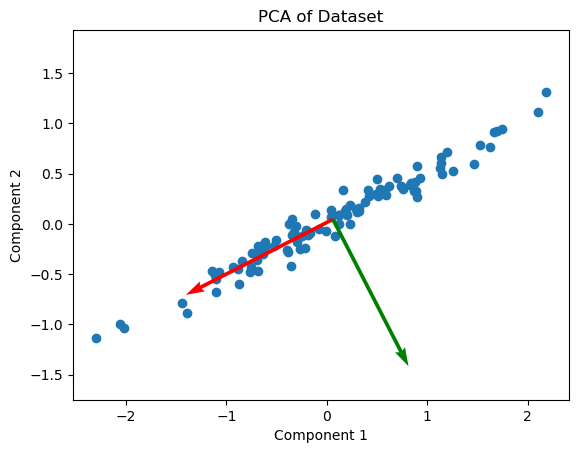

In [16]:
plot_data_with_pcs(data_matrix, Vh)

# Approximate 1D

Eliminating the lesser principal component and approximating the data with only the first principal component, the data is approximated to a 1D line. This is done by simply setting the second singular value to 0 inside the matrix of singular values given by `S`, and then reversing the PCA by multiplying the matrices `U`, `S`, and `Vh`.

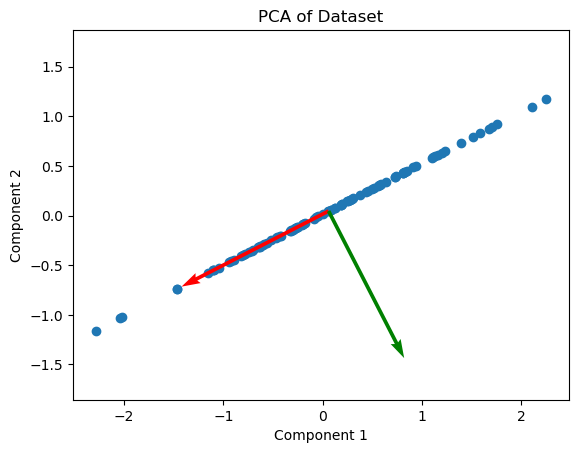

In [17]:
# Supply 1 to reverse_pca to approximate the data to 1D
approximated_data = pca_result.reverse_pca(1)

plot_data_with_pcs(approximated_data, pca_result.Vh)

# Image

We load the racoon image in gray and perform PCA on it.

**Note:** `scipy.misc.face` from the exercise sheet is deprecated because `scipy.misc` is deprecated. We use `scipy.datasets.face` instead.

Scaling the image to 249x185 pixels, we know that the image has **185 principal components.**

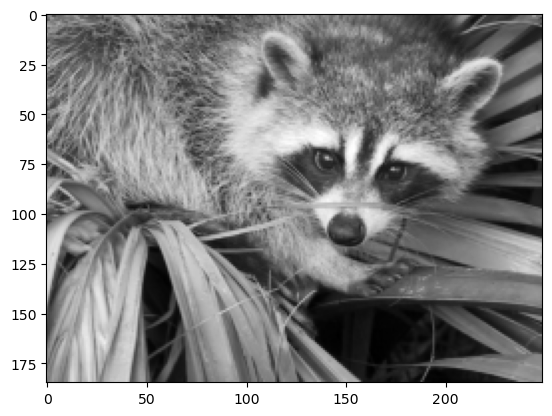

In [18]:
# Load image as `ndarray`
my_image = sc.datasets.face(gray=True)
my_image = rescale_img(my_image, 249, 185)

plt.imshow(my_image, cmap='gray')

# PCA on image
We perform PCA on the image, and print some of the singular values.

In [19]:
# We use the columns as datapoints, hence specify the flag. This 'flattens' the image
# The flag also ensures that the reconstructed image is transposed back to the original shape
pca_result_img = PCA.pca(my_image, treat_columns_as_datapoints=True)

print_pca_info(pca_result_img, 5)

There are 185 principal components, ordered by magnitude
First 5 singular values: [23.26146189 16.99451327 13.01631647 10.3419879   9.04499961]
First 5 energies: [0.32091948 0.17129296 0.10048431 0.06343517 0.04852205]
Sum of largest 5 energies: 0.7046539781006238


# Visualization of reconstructions

We visualize for different numbers of components.

Slight quality detriments are noticeable starting from 50 components, especially around the racoon's fur.

The image with 10 components is barely recogniziable despite preserving over 83% of the energy. The racoon's face is still possible to identify.

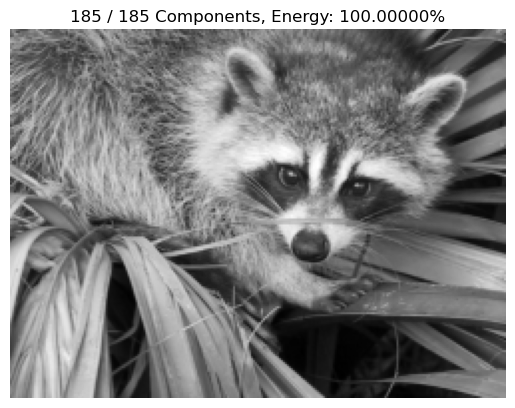

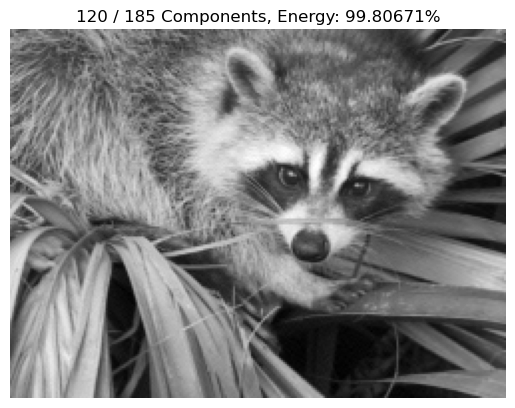

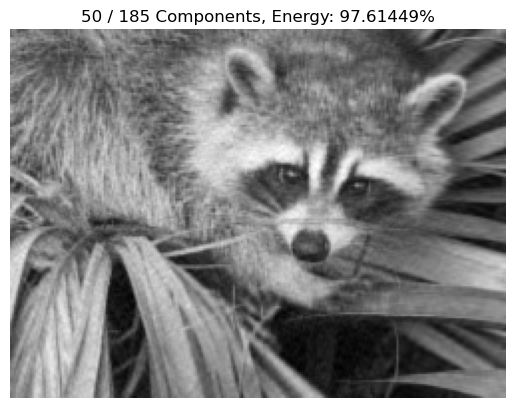

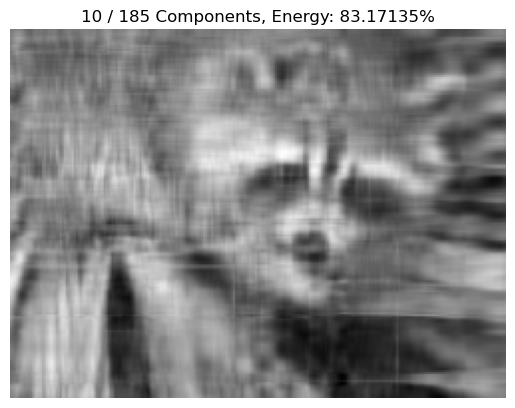

In [20]:
# Visualize reconstructions with different numbers of principal components
for num_components in [pca_result_img.S.shape[0], 120, 50, 10]:
    plot_reconstructed_image(pca_result_img, num_components, my_image.shape)


Number of components for less than 1% energy loss

In [21]:
# Find the number of components needed to retain a percentage of the energy
energy_threshold = 0.99
n = pca_result_img.S.shape[0]
while np.sum(pca_result_img.energy[:n-1]) > energy_threshold:
    n -= 1

print(f'Number of components needed to retain 99% of the energy: {n}')
print(f'We can remove {pca_result_img.S.shape[0] - n} dimensions from our image\'s columns while retaining {energy_threshold*100}% of the information')

Number of components needed to retain 99% of the energy: 76
We can remove 109 dimensions from our image's columns while retaining 99.0% of the information


Part 3.1: Visualizing the path of the ﬁrst two pedestrians in the two-dimensional space

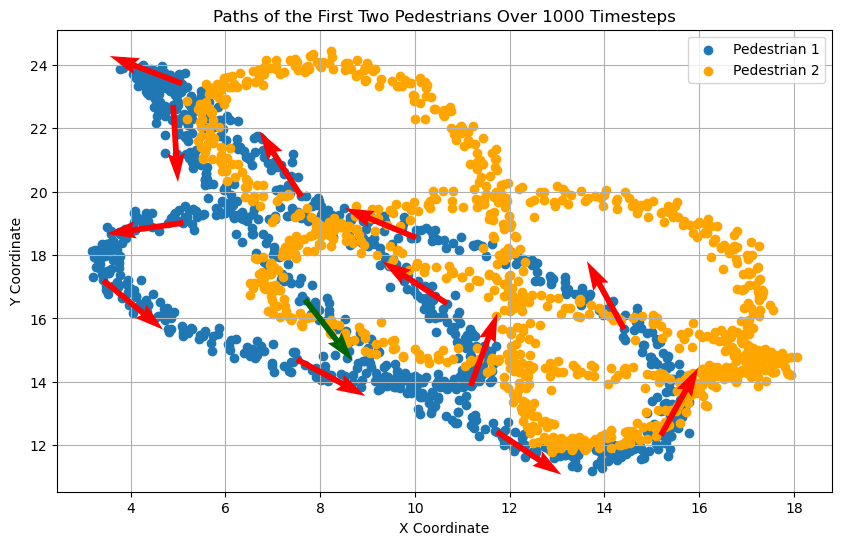

In [22]:
import matplotlib.pyplot as plt

def load_first_two_pedestrian_trajectories(file_path):
    # Initialize lists to hold the coordinates for the first two pedestrians
    x1, y1, x2, y2 = [], [], [], []
    
    with open(file_path, 'r') as file:
        for line in file:
            # Split the line by space and convert each part to float
            coords = list(map(float, line.split()))
            # Append the coordinates of the first pedestrian to x1 and y1
            x1.append(coords[0])
            y1.append(coords[1])
            # Append the coordinates of the second pedestrian to x2 and y2
            x2.append(coords[2])
            y2.append(coords[3])

            # print(f"Pedestrian 1: x = {coords[0]}, y = {coords[1]}")
            # print(f"Pedestrian 2: x = {coords[2]}, y = {coords[3]}")
    return x1, y1, x2, y2

x1, y1, x2, y2 = load_first_two_pedestrian_trajectories('data_DMAP_PCA_vadere.txt')


def avg_over_next_n_points(x, y, t, n):
    xs = np.mean(np.array([x[t+i]-x[t] for i in range(1,n+1)], dtype=float))
    ys = np.mean(np.array([y[t+i]-y[t] for i in range(1,n+1)], dtype=float))
    norm = np.sqrt(xs**2 + ys**2)
    return xs/norm, ys/norm

def plot_avg_vector(x, y, d, num_avg_points = 40):
    for i in range(0, 1000-num_avg_points, d):
        my_color = 'r'
        # plot starting vector in green
        if i == 0: my_color = 'darkgreen'
        avg = avg_over_next_n_points(x, y, i, num_avg_points)
        plt.quiver(x[i], y[i], avg[0], avg[1],scale=10, color=my_color,zorder=2)


# Plotting the paths for the first two pedestrians
plt.figure(figsize=(10, 6))
plt.scatter(x1, y1, label='Pedestrian 1', marker='o')
plt.scatter(x2, y2, label='Pedestrian 2', marker='o', color='orange')

# Plot trajectory vectors vectors
plot_avg_vector(x1, y1, 75, 30)

plt.title('Paths of the First Two Pedestrians Over 1000 Timesteps')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()


Part 3.1: Visualizing the path of the ﬁrst two pedestrians in the two-dimensional space: Gradient Coloring

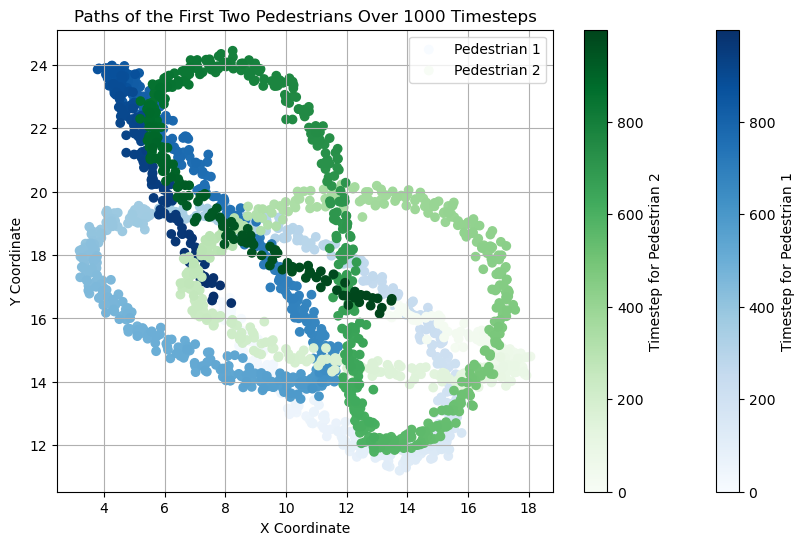

In [23]:
import matplotlib.pyplot as plt

def load_first_two_pedestrian_trajectories(file_path):
    # Initialize lists to hold the coordinates for the first two pedestrians
    x1, y1, x2, y2 = [], [], [], []
    
    with open(file_path, 'r') as file:
        for line in file:
            # Split the line by space and convert each part to float
            coords = list(map(float, line.split()))
            # Append the coordinates of the first pedestrian to x1 and y1
            x1.append(coords[0])
            y1.append(coords[1])
            # Append the coordinates of the second pedestrian to x2 and y2
            x2.append(coords[2])
            y2.append(coords[3])

            # print(f"Pedestrian 1: x = {coords[0]}, y = {coords[1]}")
            # print(f"Pedestrian 2: x = {coords[2]}, y = {coords[3]}")
    return x1, y1, x2, y2

x1, y1, x2, y2 = load_first_two_pedestrian_trajectories('data_DMAP_PCA_vadere.txt')

# Plotting the paths for the first two pedestrians
plt.figure(figsize=(10, 6))
# Create a time array from 0 to the number of points for pedestrian 1
t1 = list(range(len(x1)))
# Create a scatter plot for pedestrian 1, with the color representing time
plt.scatter(x1, y1, c=t1, label='Pedestrian 1', cmap='Blues')
plt.colorbar(label='Timestep for Pedestrian 1')

# Create a time array from 0 to the number of points for pedestrian 2
t2 = list(range(len(x2)))
# Create a scatter plot for pedestrian 2, with the color representing time
plt.scatter(x2, y2, c=t2, label='Pedestrian 2', cmap='Greens')
plt.colorbar(label='Timestep for Pedestrian 2')


plt.title('Paths of the First Two Pedestrians Over 1000 Timesteps')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()


# Third Part: Vadere pedestrian trajectory data

We load the data from the file and perform PCA on it.

In [24]:
with open("data_DMAP_PCA_vadere.txt", 'r') as file:
    # Load data inta a Python ndarray, shape (100, 2)
    global trajectory_matrix
    trajectory_matrix = np.loadtxt(file, delimiter=' ')
    print(f'Trajectory matrix shape: {trajectory_matrix.shape}')
    assert trajectory_matrix.shape == (1000, 30)

Trajectory matrix shape: (1000, 30)


# The data represents 15 pedestrians with coordinates (x, y). The columns are the timesteps

We visualize the points for a given timestep

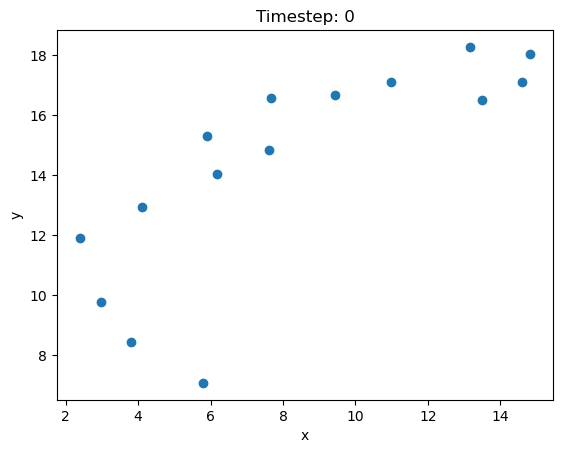

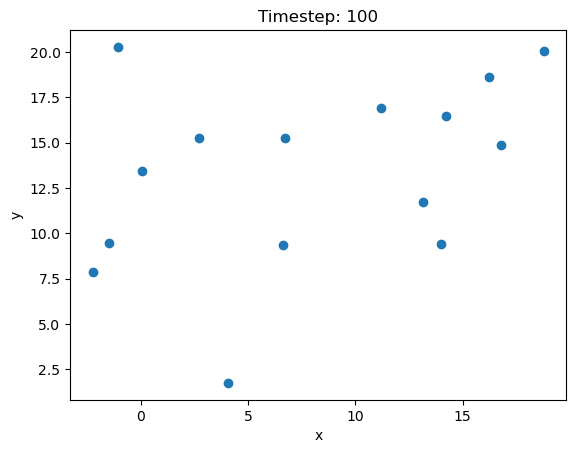

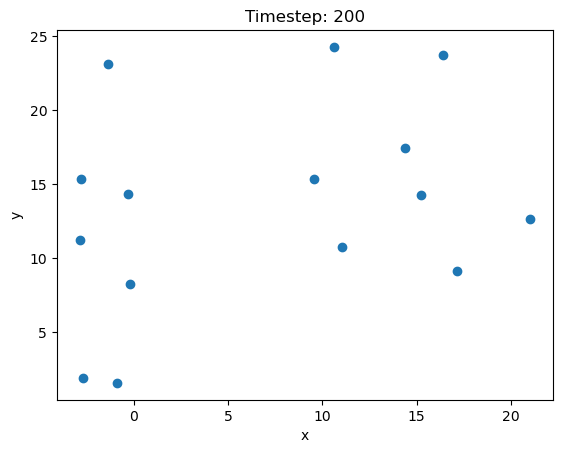

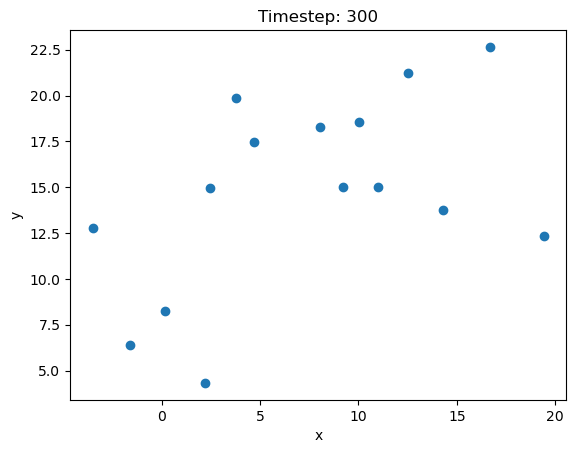

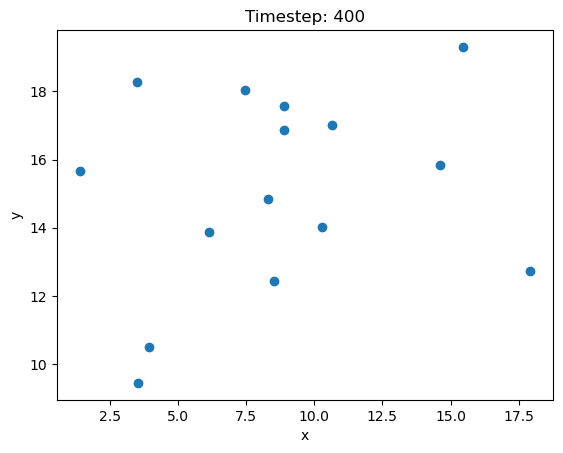

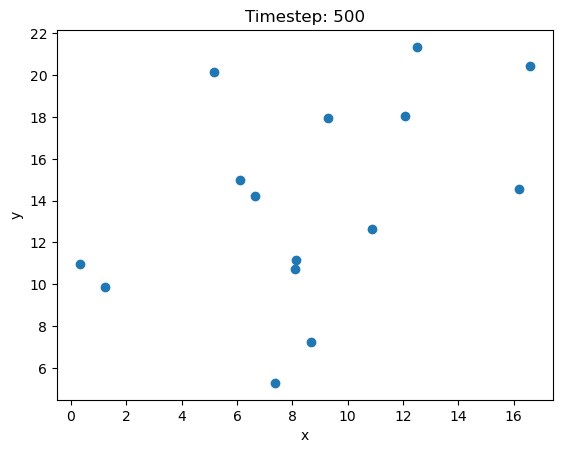

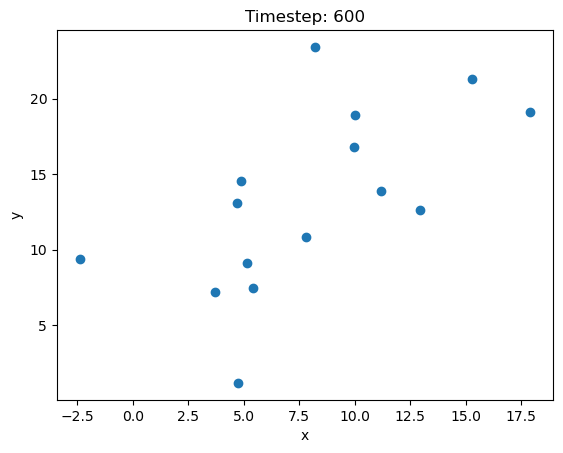

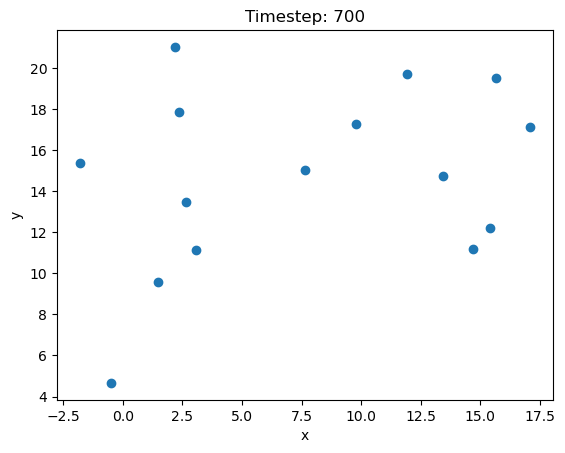

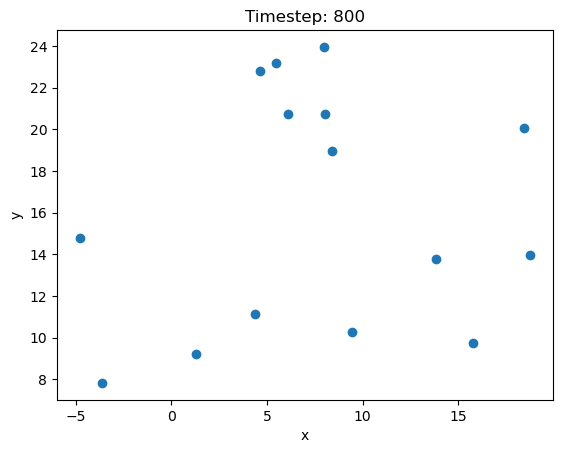

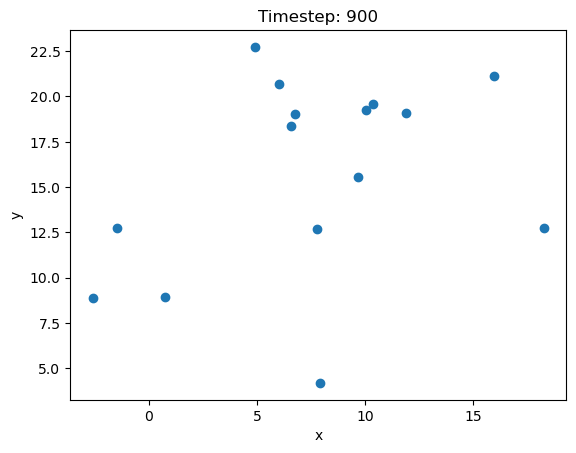

In [25]:
def plot_trajectory(timestep):
    # timesteps are rows
    trajectory = trajectory_matrix[timestep]
    x = trajectory[::2]
    y = trajectory[1::2]
    plt.scatter(x, y)
    plt.title(f'Timestep: {timestep}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
# plot_trajectory(0)

# Plot trajectories over time:

for i in range(0, 1000, 100):
    plot_trajectory(i)